# Macro-Induced Lightning Constraints

In [1]:
"""
    TITLE   : Macro-Induced Lightning Constraints
    AUTHOR  : Jagjit Sidhu, Nathaniel Starkman
    PROJECT : https://github.com/nstarman/macro_lightning
""";

__author__ = ['Jagjit Sidhu', "Nathaniel Starkman"]

<span style='font-size:30px;font-weight:650'>
    About
</span>

This notebook contains the calculations for how well macro-induced lightnint on Earth and Jupiter can constrain macro models.


<br><br>

- - - 


## Prepare

### Imports

In [89]:
# BUILT-IN

import csv
import io
import itertools
import os
import sys


# THIRD PARTY

from astropy import units as u
from astropy.table import QTable
from astropy.units import Quantity

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
from numpy.linalg import norm

import scipy
from scipy.interpolate import interp1d

import utilipy


# PROJECT SPECIFIC

sys.path.insert(0, "../")
import src


### Parameters

In [3]:
# velocities

PI = np.pi
KMS = u.km / u.s

v1_ref = 42.1 * KMS
vy_ref = 200.0 * KMS
vvir = 250 * KMS
vesc = 550 * KMS

gc_v_start = -500 * KMS
v_step = 50 * KMS

vels = np.arange(
    gc_v_start.to_value(KMS),
    (vesc + v_step).to_value(KMS),
    v_step.to_value(KMS)
)[::-1] * KMS

ref_sigmax = 6e-8 * u.cm**2


### Functions

In [4]:
def as_quantity(a):
    """Convert argument to a Quantity (or raise NotImplementedError)."""
    try:
        return Quantity(a, copy=False, subok=True)
    except Exception:
        raise NotImplementedError

# /def

def qsquare(*args):
    """Quantity Squared."""
    return np.square(as_quantity(args))

# /def

def qnorm(*args):
    """Quantity Norm."""
    return np.linalg.norm(as_quantity(args))

# /def

In [5]:
# def f_BM(vx, vvir):
#     """Equation 3 of https://arxiv.org/pdf/1908.00557.pdf.
    
#     Parameters
#     ----------
#     vx : Quantity
#         With physical type "speed"
#     vvir : Quantity
#         The virial velocity
#         With physical type "speed"

#     Returns
#     -------
#     Quantity

#     """
#     norm = 4 * PI * vx ** 2. / np.power(PI * vvir ** 2, 3. / 2.)
#     exp = np.exp(-np.square(vx / vvir))

#     return norm * exp

# # /def

def f_BM_bin(vx, vbin, vvir):
    """Equation 3 of https://arxiv.org/pdf/1908.00557.pdf.
    
    Parameters
    ----------
    vx : Quantity
        With physical type "speed"
    vvir : Quantity
        The virial velocity
        With physical type "speed"

    Returns
    -------
    Quantity

    """
    norm = vbin**3 / np.power(PI * vvir ** 2., 3. / 2.)
    exp = np.exp(-np.square(vx / vvir))

    return norm * exp

# /def


### Data

In [6]:
# micalines = src.data.load_mica_constraint()  # TODO get file

superbursts = src.data.load_superbursts_polygon()
superbursts1 = src.data.load_superbursts1_polygon()

humanmass = src.data.humanmass
humancross = src.data.humancross
humanupper = src.data.humanupper

DFNmass = src.data.DFNmass
DFNcrosssection = src.data.DFNcrosssection
DFNupper = src.data.DFNupper
DFNfuturemass = src.data.DFNfuturemass
DFNfuturecrosssection = src.data.DFNfuturecrosssection
DFNfutureupper = src.data.DFNfutureupper

WD = src.data.WD


<br><br>

- - - 


## Earth

We first perform the integral $$\Gamma(M_x, \sigma_x) = A_{det}\frac{\rho_{DM}}{M_x} \int_{v_{threshold}(\sigma_x;D)}^{v_{esc}}v_x f_{MBSS}(v_x) \rm{d}v_x $$

from https://arxiv.org/pdf/1908.00557.pdf

In [106]:
# constants
Arho = 3 * u.g * u.s / u.m  # A_{det}*\rho_{DM}
sigma_factor = 1e4 * u.m**2 * u.cm**2 / u.s**2



In [27]:
vbar = 0.0
Vhold = 800.0 * u.km / u.s

Mx_unit = u.g
sigma_unit = u.cm**2

Mhold=[]
Shold=[]

# calculate Mx
for vx, vz, vy in itertools.product(vels, vels, vels):  # why this order?
    if qnorm(vx, vy, vz) <= vesc:
        _v = qnorm(vx, vy, vz)
        maxwellian = f_BM_bin(_v, vbin=v_step, vvir=vvir)  # TODO understand normalization        
        vrel = qnorm(v1_ref, vx, vy-vy_ref, vz)

        vbar = vbar + vrel * maxwellian  # cumulative
        Mx = (Arho * vbar).to_value(Mx_unit)
        
        Mhold.append(Mx)

# calculate sigmax
for vx, vz, vy in itertools.product(vels, vels, vels):  # why this order?
    if qnorm(vx, vy, vz) <= vesc:
        vrel = qnorm(v1_ref, vx, vy-vy_ref, vz)
        if Vhold < vrel:
            vrel = Vhold

        sigmax = (sigma_factor / vrel**2)
        if sigmax < ref_sigmax:
            sigmax = ref_sigmax

        Shold.append(sigmax.to_value(sigma_unit))

        Vhold = vrel    # problem? never reset Vhold

# /for

Mhold = np.array(Mhold) * Mx_unit
Shold = np.array(Shold) * sigma_unit


In [86]:
M = []
S = []

powers = [i*10**n for n in range(1, 10) for i in range(1, 10)] * Mhold.unit

for p, k in zip(powers[:-1], powers[1:]):
    sel = (p < Mhold) & (Mhold < k)
    if sum(sel) > 0.:
        M.append((p + k) / 2)
        S.append(min(Shold[sel]))

M = as_quantity(M)
S = as_quantity(S)

In [150]:
sel = S > 6e-8 * u.cm**2  # TODO make a parameter

macro = QTable([M[sel], S[sel]], names=["mass", "sigma"])
macro[:1]

mass,sigma
g,cm2
float64,float64
25000.0,6.181523783938187e-08


In [182]:
z = np.polyfit(macro["mass"].to_value(u.g), macro["sigma"].to_value(u.cm**2), 8)
# z.__doc__ = """Map mass to sigma."""
p = np.poly1d(z)

sigmalightning = np.polyval(z, macro["mass"].value) * u.cm**2
sigmalightning

<Quantity [1.22685577e-07, 7.20201098e-08, 5.10326376e-08, 5.22355328e-08,
           6.91296187e-08, 9.61535388e-08, 1.28630751e-07, 1.62714588e-07,
           2.75494395e-07, 1.17552935e-07, 6.47121429e-07, 2.69085135e-06,
           5.12434913e-06, 6.06312425e-06, 5.43798403e-06, 5.69751608e-06,
           5.63548176e-06] cm2>

In [192]:
masslightning = macro["mass"]
upperlightning = masslightning * 1e4 * u.cm**2 / u.g # why? UNITS!  sigma_factor

masslightning = np.insert(masslightning, 0, values=6e-4 * u.g)
sigmalightning = np.insert(sigmalightning, 0, values=6e-8 * u.cm**2)
upperlightning = np.insert(upperlightning, 0, values=6e-8 * u.cm**2)

print(masslightning.value, upperlightning.value,
      sigmalightning.value, sep="\n")

[6.0e-04 2.5e+04 3.5e+04 4.5e+04 5.5e+04 6.5e+04 7.5e+04 8.5e+04 9.5e+04
 1.5e+05 2.5e+05 3.5e+05 4.5e+05 5.5e+05 6.5e+05 7.5e+05 8.5e+05 9.5e+05]
[6.0e-08 2.5e+08 3.5e+08 4.5e+08 5.5e+08 6.5e+08 7.5e+08 8.5e+08 9.5e+08
 1.5e+09 2.5e+09 3.5e+09 4.5e+09 5.5e+09 6.5e+09 7.5e+09 8.5e+09 9.5e+09]
[6.00000000e-08 1.22685577e-07 7.20201098e-08 5.10326376e-08
 5.22355328e-08 6.91296187e-08 9.61535388e-08 1.28630751e-07
 1.62714588e-07 2.75494395e-07 1.17552935e-07 6.47121429e-07
 2.69085135e-06 5.12434913e-06 6.06312425e-06 5.43798403e-06
 5.69751608e-06 5.63548176e-06]


<ipython-input-169-afb3c63985be>:15: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  ax.fill_between(M1, ymin, BH(M1), where=None,color='1', edgecolor='', hatch="+",alpha=1,zorder=2)



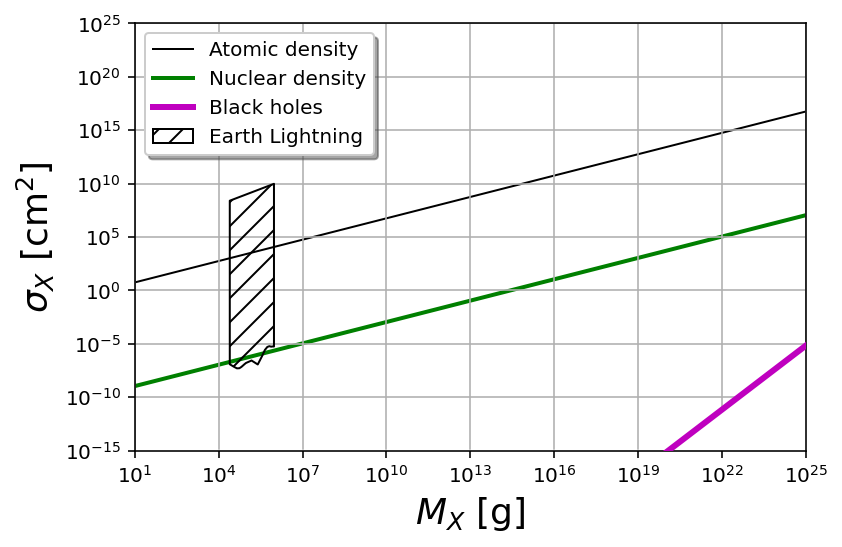

In [169]:
# Define Plot
fig, ax = plt.subplots(figsize=(6, 4))

ax.set_xlabel('$M_\t{X}$ [g]',fontsize=18)
ax.set_xlim([M1.min(), M1.max()])
ax.set_ylim([1e-15, 1e25])  # min/max of nuclear_density(M1)
ax.set_ylabel('$\sigma_\t{X}$ [cm$^{2}$]',fontsize=18)

# Constraints
M1 = np.logspace(1,25)
ax.loglog(M1, atomic_density(M1), 'k', markersize=4, color='k',lw=1,label='Atomic density',zorder=0)
ax.loglog(M1, nuclear_density(M1), 'k', markersize=4, color='g',lw=2,label='Nuclear density',zorder=0)

ax.loglog(M1, BH(M1), 'k', markersize=4, color='m',lw=3,label='Black holes',zorder=3)
ax.fill_between(M1, ymin, BH(M1), where=None,color='1', edgecolor='', hatch="+",alpha=1,zorder=2)

# Earth Lightning
plt.fill_between(
    masslightning, sigmalightning, upperlightning,
    where=None, 
    facecolor='none',
    edgecolor='black',
    hatch="//",
    alpha=1.0,
    zorder=8,
    label="Earth Lightning"
)

ax.legend(loc='upper left', shadow=True)
ax.grid(True)
plt.tight_layout()

plt.show();

## Jupiter

In [157]:
def CMB(M):
    return 4.5e-7 * M

#Nuclear Density
def nuclear_density(M):
    f = PI * (3/(4*PI*3.6e14))**(2./3) * np.power(M, 2./3.)
    return f

#Black Holes
def BH(M):
    f = PI*(3e5)**2 *(M/(2e33))**2
    return f

#Atomic Density
def atomic_density(M):
    f = PI*(3/(4*PI * 1e0))**(2./3) *pow(M,2./3)
    return f

def KeplerTop(M):
    f = 1e-6*M
    return f

def LMCTop(M):
    f = 1e-4*M
    return f

In [61]:
jupitermasslightning = masslightning[:] * 2e3
uppersigmalightningjupiter = jupitermasslightning[:] * 1e-4

print(jupitermasslightning, uppersigmalightningjupiter, sep="\n")

[1.2e+00 5.0e+07 7.0e+07 1.1e+08 1.5e+08 1.9e+08 3.0e+08 5.0e+08 7.0e+08
 9.0e+08 1.9e+09]
[1.2e-04 5.0e+03 7.0e+03 1.1e+04 1.5e+04 1.9e+04 3.0e+04 5.0e+04 7.0e+04
 9.0e+04 1.9e+05]


In [215]:
vbar = 0.0 * u.km / u.s
Vhold = 800.0 * u.km / u.s

Mx_unit = u.g
sigma_unit = u.cm**2

Mhold=[]
Shold=[]

sigma_factor = 1e-10 * u.cm**6  # TODO why units?

# calculate Mx
for vx, vz, vy in itertools.product(vels, vels, vels):  # why this order?
    _v = qnorm(vx, vy, vz)

    if (vvir < _v) & (_v <= vesc):  # TODO WHY?
        maxwellian = f_BM_bin(_v, vbin=v_step, vvir=vvir)  # TODO understand normalization        
        vrel = qnorm(v1_ref, vx, vy-vy_ref, vz)

        vbar = vbar + vrel * maxwellian  # cumulative

        Mx = (1e5/3 * (u.g * u.s / u.m) * vbar).to_value(Mx_unit)  # TODO why?
        Mhold.append(Mx)
# /for 

# calculate sigmax
for vx, vz, vy in itertools.product(vels, vels, vels):  # why this order?
    _v = qnorm(vx, vy, vz)
    if (vvir < _v) & (_v <= vesc):  # TODO WHY?
        vrel = qnorm(v1_ref, vx, vy-vy_ref, vz)
        if Vhold < vrel:
            vrel = Vhold

        sigmax = np.power(sigma_factor * (vvir / vrel)**7, 1./3)
        # if sigmax < ref_sigmax:  # TODO why not this?
        #     sigmax = ref_sigmax
        Shold.append(sigmax.to_value(sigma_unit))

        Vhold = vrel    # problem? never reset Vhold

# /for

Mhold = np.array(Mhold) * Mx_unit
Shold = np.array(Shold) * sigma_unit

Mhold

<Quantity [2.22182445e+05, 4.38688564e+05, 6.87802989e+05, ...,
           7.30001442e+09, 7.30027891e+09, 7.30052243e+09] g>

In [216]:
Mhold.value
Shold.value

array([2.22182445e+05, 4.38688564e+05, 6.87802989e+05, ...,
       7.30001442e+09, 7.30027891e+09, 7.30052243e+09])

array([6.34075195e-05, 7.39435960e-05, 7.39435960e-05, ...,
       6.20382546e-03, 6.20382546e-03, 6.20382546e-03])

In [220]:
vxs = []
for vx, vz, vy in itertools.product(vels.value, vels.value, vels.value):
    vxs.append(vx)
np.shape(vxs)

(10648,)

In [221]:
vxs = []

for i in range(0,22):
    vx=550.0-i*50.0
    for j in range(0,22):
        vz=550.0-j*50.0
        for k in range(0,22):
            vy=550.0-k*50.0  #this is in the Galactic rest frame
            vxs.append(vx)
np.shape(vxs)

(10648,)

In [214]:
Mhold=[]
Shold=[]

vbar=0.0
f=0.0
Vhold = 800.0

for i in range(0,22):
    vx=550.0-i*50.0
    for j in range(0,22):
        vz=550.0-j*50.0
        for k in range(0,22):
            vy=550.0-k*50.0  #this is in the Galactic rest frame
            
            if (np.sqrt(vx**2+vy**2+vz**2)>550.0):
                pass

            elif(np.sqrt(42.1**2+vx**2+vz**2+(vy-200.0)**2)>250.0):
                vrel=np.sqrt(42.1**2+vx**2+vz**2+(vy-200.0)**2)
                vbar=vbar+(vrel)*np.exp(-(vx**2+vy**2+vz**2)/(250.0**2))*(50.0**3)/(np.pi*250.0**2)**1.5
                Mx=1e5*vbar*1e3/3

                if Vhold<vrel:
                    vrel=Vhold
                else:
                    vrel=np.sqrt(42.1**2+vx**2+vz**2+(vy-200.0)**2)

                sigmax=(10**-10*(250/vrel)**7)**(1/3)

                Mhold.append(Mx)
                Shold.append(sigmax)
                Vhold=vrel
                
Mhold = np.array(Mhold)
Shold = np.array(Shold)
Mhold
Shold

array([2.22182445e+05, 4.38688564e+05, 6.87802989e+05, ...,
       9.34974331e+09, 9.35000781e+09, 9.35025133e+09])

array([6.34075195e-05, 7.39435960e-05, 7.39435960e-05, ...,
       4.49260261e-04, 4.49260261e-04, 4.49260261e-04])

In [83]:
M = []
S = []

for k, i in itertools.product(range(5,15), range(1,9)):
    sel = (i*10**k < Mhold) & (Mhold < (i+1)*10**k)
    if sum(sel) > 0:
        S.append(min(Shold[sel]))
        M.append((2*i+1) * 10**k / 2)

np.array(S)

array([6.34075195e-05, 7.39435960e-05, 7.39435960e-05, 7.39435960e-05,
       8.17931170e-05, 8.17931170e-05, 8.72868532e-05, 8.72868532e-05,
       8.72868532e-05, 9.02978842e-05, 9.02978842e-05, 9.13448065e-05,
       9.13448065e-05, 9.46251397e-05, 1.10255278e-04, 1.14934920e-04,
       1.16577666e-04, 1.16577666e-04, 1.16577666e-04, 1.18264557e-04,
       1.53039953e-04, 2.03390727e-04, 2.08172255e-04, 2.08172255e-04,
       2.87350071e-04, 2.96503070e-04, 2.96503070e-04, 4.29698127e-04,
       4.49260261e-04, 4.49260261e-04, 4.49260261e-04, 4.49260261e-04,
       4.49260261e-04, 4.49260261e-04, 4.49260261e-04])

In [93]:
jovian = np.c_[
    M + [8.5*1e9, 0.634, 250000.0],
    S + [8.5*1e9*1e-4, 6.34075194929149e-05, 6.34075194929149e-05]
]

### Plotting Phase Space Constraints

NameError: name 'micalines' is not defined

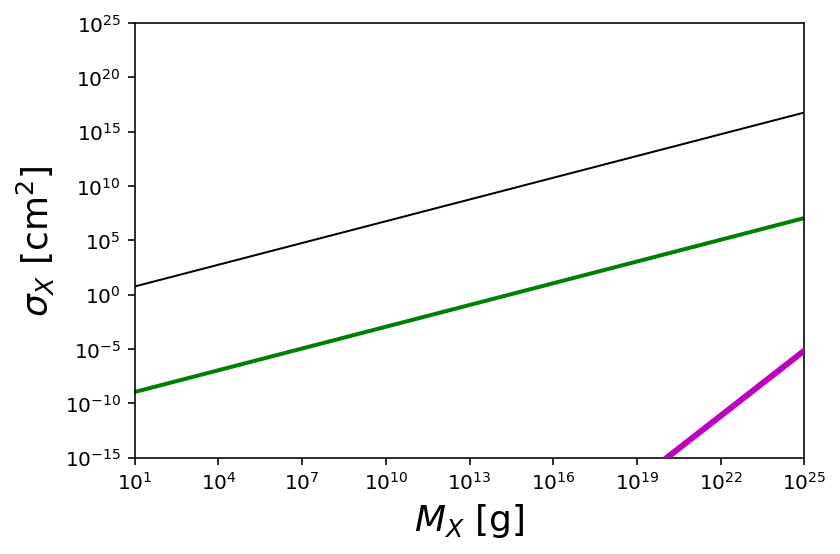

In [95]:
M1=np.logspace(1,25)
MMica = np.logspace(-10, 2.204)# for M_max=160g
MMica1 = np.logspace(-12,1.43,num=1000)#  2.204 for M_max=160g  1.74 for M_max = 55g  1.43 for M_max=27.5g
MMica2 = np.logspace(1.43,1.74,num=1000)
Mmicro = np.logspace(23.0,28.0)

#Define Plot
fig = plt.figure()
ax = fig.add_subplot(111)

#X-axis
ax.set_xlabel('$M_\t{X}$ [g]',fontsize=18)
ax.set_xlim([M1.min(),M1.max()])

#Y-axis
ymin=10**-15#nuclear_density(M1).min()#10**(-15)
ymax=float(10**25)#nuclear_density(M1).max()#10**15
ax.set_ylim([ymin,ymax])
ax.set_ylabel('$\sigma_\t{X}$ [cm$^{2}$]',fontsize=18)

#Make Plot
ax.loglog(M1, atomic_density(M1), 'k', markersize=4, color='k',lw=1,label='Atomic density',zorder=0)
ax.loglog(M1, nuclear_density(M1), 'k', markersize=4, color='g',lw=2,label='Nuclear density',zorder=0)
ax.loglog(M1, nuclear_density(M1), 'k', markersize=4, color='m',lw=3,label='Black holes',zorder=3)

#commenting out lines below here will remove some exclusion regions
#each pair of lines is one constraint

line3 = plt.Polygon(micalines, closed=None, fill=True, facecolor='yellow', edgecolor='black',alpha=0.8, hatch="|",lw=1,zorder=0)# edgecolor='r'
plt.gca().add_line(line3) #e.g. only need to comment out this line (plt.gca()...)to remove mica constraints,
#but you can comment out both the above lines if you want

lineWD = plt.Polygon(WD, closed=None, fill=True, facecolor='blue', edgecolor='black',alpha=0.6, hatch="",lw=1,zorder=2)# edgecolor='r'
plt.gca().add_line(lineWD)

plt.fill_between(M1, CMB(M1),ymax,where=None, color='grey',edgecolor='black',hatch="",alpha=.7,zorder=1)#SIDM ,alpha=.5

linen = plt.Polygon(superbursts, closed=None, fill=True, facecolor='purple', edgecolor='black',alpha=0.6, hatch="",lw=1,zorder=5)# edgecolor='r'
plt.gca().add_line(linen)

# linelightning = plt.Polygon(lightning, closed=None, fill=True, facecolor='cyan', edgecolor='black',alpha=1, hatch="",lw=1,zorder=4)# edgecolor='r'
# plt.gca().add_line(linelightning)

# linejovian = plt.Polygon(jovian, closed=None, fill=True, facecolor='none', edgecolor='black',alpha=1, hatch="+",lw=1,zorder=3)# edgecolor='r'
# plt.gca().add_line(linejovian)

linen1 = plt.Polygon(superburst1, closed=None, fill=True, facecolor='purple', edgecolor='black',alpha=0.6, hatch="//",lw=1,zorder=5)# edgecolor='r'
plt.gca().add_line(linen1)

plt.fill_between(masslightning,sigmalightning ,upperlightning,where=None, facecolor='none',edgecolor='black',hatch="//",alpha=1.0,zorder=8)

plt.fill_between(jupitermasslightning,sigmalightning ,uppersigmalightningjupiter,where=None, facecolor='none',edgecolor='cyan',hatch="//",alpha=1.0,zorder=4)


# plt.fill_between(humanmass,humancross ,humanupper,where=None, facecolor='red',edgecolor='black',hatch="",alpha=1.0,zorder=5)
plt.fill_between(humanmass,humancross ,humanupper,where=None, facecolor='red',edgecolor='black',hatch="",alpha=1.0,zorder=5)
plt.fill_between(DFNmass,DFNcrosssection ,DFNupper,where=None, facecolor='green',edgecolor='black',hatch="",alpha=1.0,zorder=6)

# comment out lines below to remove lensing constraints, each line is a constraint itself
#unlike the above lines
plt.fill_between(Mmicro, BH(Mmicro), LMCTop(Mmicro), where=None,facecolor='brown', edgecolor='black', hatch="/",alpha=1,zorder=2) #BH ,label='BH',


plt.fill_between(M1, ymin, BH(M1), where=None,color='1', edgecolor='', hatch="+",alpha=1,zorder=2) #BH ,label='BH',

leghumans = Rectangle((0, 0), 1, 1, fc='purple',edgecolor='black', hatch="",alpha=0.6)
legbol = Rectangle((0, 0), 1, 1, fc="purple",edgecolor='black', hatch="/",alpha=0.6)
legbol2 = Rectangle((0, 0), 1, 1, fc='none',edgecolor='green', hatch="+",alpha=0.6)
legfluo = Rectangle((0, 0), 1, 1, fc="none",edgecolor='blue', hatch="//",alpha=1)
leggranite= Rectangle((0, 0), 1, 1, fc="none",edgecolor='purple', alpha=1,hatch="\ ")

leg = ax.legend(loc='upper left', shadow=True)
ax.grid(True)
plt.tight_layout()
plt.savefig('lightningconstraints.pdf')

plt.show();

<br><br>

- - - 

<span style='font-size:40px;font-weight:650'>
    END
</span>